# Analysis of the attack: Adult with Clustering based on Targets
Analysis of the attack on Adult with the clustering cumputed considering the target variable.
The data used for this attack are generated without the noisy validation dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../") 
import mlem

In [2]:
import warnings

Loading the bb and data

In [3]:
BLACK_BOX_PATH = './adult_randomforest_and_datasets/adult_randfor.bz2'
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/risultati_clustered_gaussian_corretti/gaussian/same"
BLACK_BOX_DATA_PATH = './adult_randomforest_and_datasets/adult_randfor.data.npz'
TRAIN_SET_CSV = 'adult_randomforest_and_datasets/adult_trainset.csv'
TEST_SET_CSV  = 'adult_randomforest_and_datasets/adult_testset.csv'
#NOISY_VALIDATION_SET_CSV = ''
CENTROIDS_NEIGHBORS = 'adult_randomforest_and_datasets/adult_clustered_5_closest.csv'

In [4]:
def get_attack_mod(index:int, targets=[0,1], base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        
def get_local_model(index:int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Local model
    """
    path = f"{base_folder}/{index}/black_box"
    local_model_path = f"{path}/model.pkl.bz2"
    with bz2.BZ2File(local_model_path) as lm:
        local_model = pickle.load(lm)
    return local_model

def get_local_model_data(index: int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Structure with keys x and y
    """
    path = f"{base_folder}/{index}/black_box"
    data_path = f"{path}/data.npz"
    loaded = np.load(data_path, allow_pickle=True)
    return loaded

def get_subset_target_cluster(df, target, cluster):
    """
    Returns the subset of a dataframe with the specified target and cluster.
    """
    tmp = df[df['Target'] == target]
    return tmp[tmp['Cluster'] == cluster]

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

loading the data and the black box

In [5]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)

/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
loaded = np.load(BLACK_BOX_DATA_PATH, allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [7]:
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

doing some integrity checks

In [8]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]
adult_train = pd.read_csv(TRAIN_SET_CSV)
adult_test = pd.read_csv(TEST_SET_CSV)
adult_test_subset_cluster = pd.read_csv(CENTROIDS_NEIGHBORS)
assert (adult_train[feat_cols] == x_train).all().all() and \
       (adult_test[feat_cols] == x_test).all().all()   and \
       (adult_test_subset_cluster[feat_cols] == x_test_clustered).all().all()

In [9]:
adult_train_ones = adult_train[adult_train['Target'] == 1]
adult_train_zeroes = adult_train[adult_train['Target'] == 0]

In [10]:
adult_train_ones

,Unnamed: 0,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target,Cluster
12674,26860,1.032523,0.218918,-0.310837,0.164328,-0.440434,0.455011,0.061527,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,1
12675,26865,0.880215,0.218918,1.421195,0.263198,0.344281,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,1
12676,4411,0.347133,0.218918,1.082561,0.564576,1.521353,0.455011,0.448686,0.455728,0.263855,0.313955,-0.147502,-0.218673,0.756794,0.254411,1,3
12677,24148,0.575597,0.218918,-0.042629,0.056298,-1.225149,0.455011,0.061527,0.455728,0.263855,0.313955,-0.147502,-0.218673,0.339381,0.254411,1,1
12678,28103,1.032523,0.285829,-0.062930,0.076923,-0.832791,0.455011,0.485342,0.455728,0.263855,0.313955,-0.147502,-0.218673,0.756794,0.254411,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16871,6010,-0.262102,0.218918,0.001145,0.421658,1.128996,0.455011,0.270647,0.493599,0.263855,0.113783,-0.147502,-0.218673,-0.912857,0.254411,1,3
16872,24384,0.956369,0.218918,0.388645,0.200180,-0.048076,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,4.669585,1.591619,0.254411,1,0
16873,10776,1.184832,0.558659,-0.409070,0.164328,-0.440434,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,1
16874,3612,1.032523,0.387063,4.043523,0.421658,1.128996,0.455011,0.305159,0.455728,0.129972,0.313955,0.890157,-0.218673,-0.078031,0.254411,1,3


In [11]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

Generating the classification reports and the confusion matrices.
This is the algorithm from my scheme
![schema attacco](./Images/schema.png)

ind=0 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/00_t0_c0
ind=1 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/01_t0_c0
ind=2 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/02_t0_c0
ind=3 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/03_t0_c0
ind=4 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/04_t0_c0
ind=5 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/05_t0_c1
ind=6 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/06_t0_c1
ind=7 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/07_t0_c1
ind=8 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/08_t0_c1
ind=9 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/09_t0_c1
ind=10 targ=0 clus=2 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/10_t0_c2
ind=11 targ=0 clus=2 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/11_t0_c2
ind=12 targ=0 clus=2 ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/12_t0_c2
ind=13 targ=0 clus=2 A

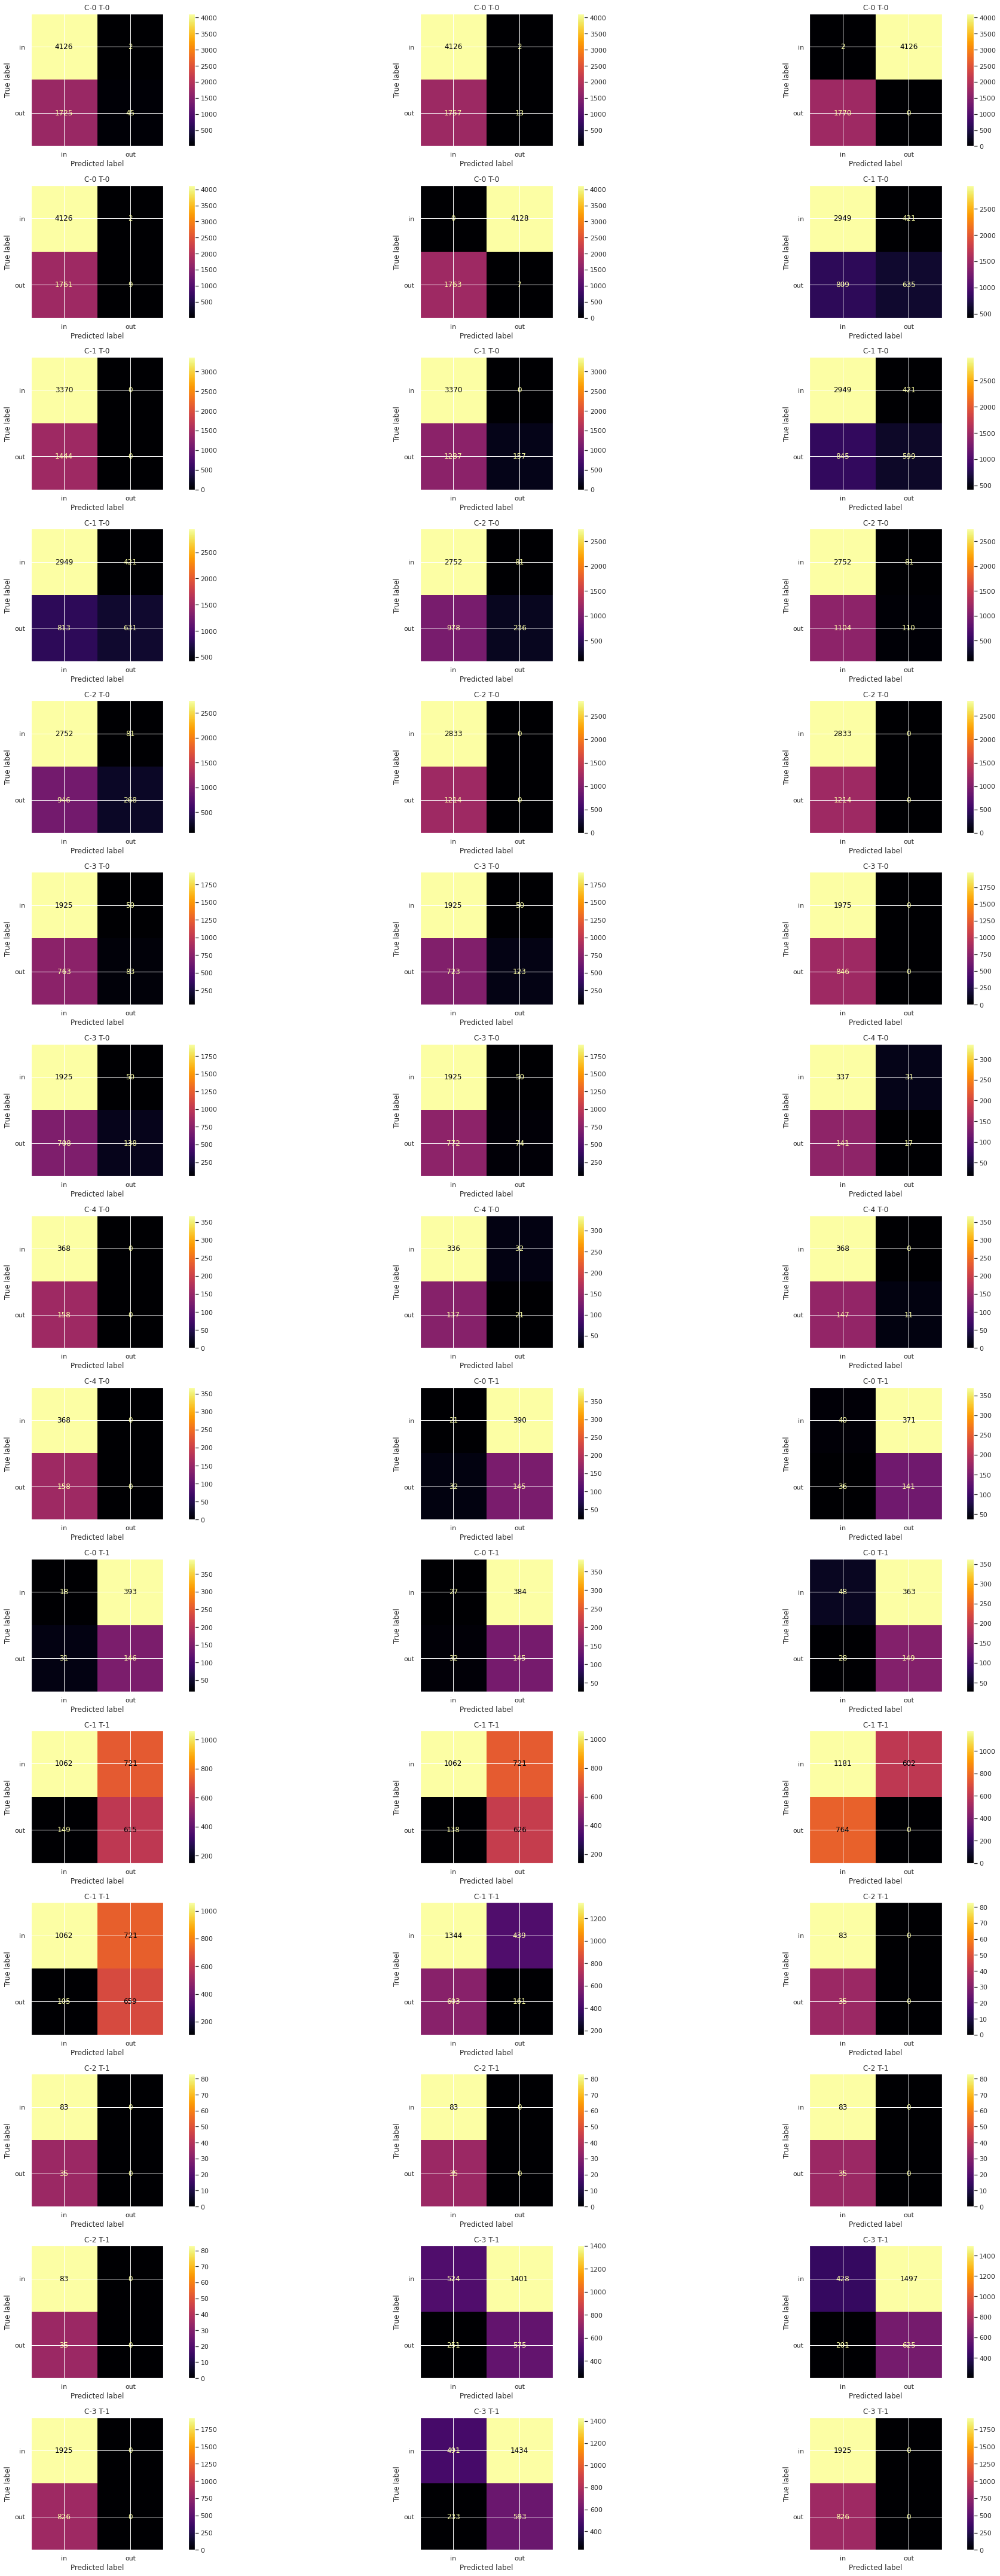

In [12]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]

BASE_RESULTS_PATH = Path("ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING")
BASE_RESULTS_PATH.mkdir(exist_ok=False)

GLOBAL_RESULTS = []
fig, axs = plt.subplots(nrows=15, ncols=3, figsize=(30, 60))
axs_list = axs.ravel()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # for each (target, cluster)...
    for ind, (targ, clus) in enumerate(adult_test_subset_cluster[['Target', 'Cluster']].values):
        ind_res_path = BASE_RESULTS_PATH / f"{ind:02d}_t{targ}_c{clus}"
        ind_res_path.mkdir(exist_ok=True)
        print(f"{ind=} {targ=} {clus=} {ind_res_path}")
        # retrieve the attack models
        attack_0, attack_1 = get_attack_mod(ind)

        # TRAIN
        train_path = ind_res_path / "train"
        train_path.mkdir(exist_ok="true")
        # get the subset of the training set
        train_subset = get_subset_target_cluster(adult_train, targ, clus)

        probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
        
        ones_train, zeroes_train = split_probs_array(probs_train)
        
        assert len(zeroes_train) + len(ones_train) == len(probs_train)

        if len(zeroes_train) > 0:
            atk_0_train = attack_0.predict(zeroes_train)
            report_0_train = classification_report(["in"]*len(atk_0_train), atk_0_train)
            with open(str(train_path / "0.txt"), "w") as f:
                f.write(report_0_train)

        if len(ones_train) > 0:
            atk_1_train = attack_1.predict(ones_train)
            report_1_train = classification_report(["in"]*len(atk_1_train), atk_1_train)
            with open(str(train_path / "1.txt"), "w") as f:
                f.write(report_1_train)
        
        l0tr = len(zeroes_train)
        l1tr = len(ones_train)
        
        train_results = None
        if l0tr == 0:
            train_results = atk_1_train
        elif l1tr == 0:
            train_results = atk_0_train
        else:
            train_results = np.concatenate((atk_0_train, atk_1_train))
        with open(str(train_path / "01.txt"), "w") as f:
            report_01_train = classification_report(["in"]*len(train_results), train_results)
            f.write(report_01_train)

        

        #TEST
        test_path = ind_res_path / "test"
        test_path.mkdir(exist_ok="true")
        # get test subset of the test set
        test_subset  = get_subset_target_cluster(adult_test, targ, clus)

        probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
        ones_test, zeroes_test = split_probs_array(probs_test)
        assert len(zeroes_test) + len(ones_test) == len(probs_test)

        if len(zeroes_test) > 0:
            atk_0_test = attack_0.predict(zeroes_test)
            report_0_test = classification_report(["out"] * len(atk_0_test), atk_0_test)
            with open(str(test_path / "0.txt"), "w") as f:
                f.write(report_0_test)

        if len(ones_test) > 0:
            atk_1_test = attack_0.predict(ones_test)
            report_1_test = classification_report(["out"] * len(atk_1_test), atk_1_test)
            with open(str(test_path / "1.txt"), "w") as f:
                f.write(report_1_test)
        
        l0te = len(zeroes_test)
        l1te = len(ones_test)
        test_results = None
        if l0te == 0:
            test_results = atk_1_test
        elif l1te == 0:
            test_results = atk_0_test
        else:
            test_results = np.concatenate((atk_0_test, atk_1_test))
            
        with open(str(test_path / "01.txt"), "w") as f:
            report_01_train = classification_report(["out"]*len(test_results), test_results)
            f.write(report_01_train)
        
        # Concatenating test and train
        with open(str(ind_res_path / "traintest_full.txt"), "w") as f:
            full = np.concatenate((train_results, test_results))
            mask = ["in"] * len(train_results) + ["out"] * len(test_results)
            f.write(classification_report(mask, full))
            aa = axs_list[ind]
            ConfusionMatrixDisplay.from_predictions(mask, full, ax=aa, cmap='inferno')
            aa.set_title(f"C-{clus} T-{targ}")
            
plt.tight_layout()

# Using a Voting classifier

Classifier which implements the hard voting, it returns arrays containing "in" / "out" / "even" (this last case is possible only if there was an even number of classifiers)

In [13]:
from typing import List
class HardVotingClassifier:
    def __init__(self, classifiers: List):
        self.classifiers_ = classifiers
        self.nclass = len(classifiers)
        assert all([x.classes_ == self.classifiers_[0].classes_] for x in self.classifiers_)
    def predict(self, x):
        """
        Returns: array with classification, containing ["in", "out", "even"]
        """
        # use 1 for "in", -1 for "out", sum all the arrays and replace the values => 0 with in
        # the ones < 0 with out, return a boolean mask to indicate the ones where there was a 50/50
        # decision (only for when the number of classifiers is even)
        def convert_to_number(x):
            if x == "in":
                return 1
            elif x == "out":
                return -1
            else:
                raise ValueError(f"invalid argument {x}")
        def convert_to_inout(x):
            if x > 0:
                return "in"
            elif x < 0:
                return "out"
            else:
                return "even"
        
                
        convert_to_number_vectorized = np.vectorize(convert_to_number)
        convert_to_inout_vectorized  = np.vectorize(convert_to_inout)    
        
        predictions = [convert_to_number_vectorized(model.predict(x)) for model in self.classifiers_]
        
        return convert_to_inout_vectorized(sum(predictions))

In [14]:
BASE_VOTING_PATH = Path(BASE_RESULTS_PATH) / "HARD_VOTING"
BASE_VOTING_PATH.mkdir(exist_ok=False)
print(BASE_VOTING_PATH)

ADULT_ANALYSIS_RESULTS_TARGETBASED_CLUSTERING/HARD_VOTING


## Hard Voting

Here the hard voting is obtained by taking all the attack models for a given target and cluster 
(for each target/cluster we have 5 attack models (10 if we consider label division)

HardVoting for t=0 c=0 indices=[0, 1, 2, 3, 4]: #Classifiers: Class0 = 5 Class1 = 5
HardVoting for t=0 c=1 indices=[5, 6, 7, 8, 9]: #Classifiers: Class0 = 5 Class1 = 5
HardVoting for t=0 c=2 indices=[10, 11, 12, 13, 14]: #Classifiers: Class0 = 5 Class1 = 5
HardVoting for t=0 c=3 indices=[15, 16, 17, 18, 19]: #Classifiers: Class0 = 5 Class1 = 5
HardVoting for t=0 c=4 indices=[20, 21, 22, 23, 24]: #Classifiers: Class0 = 5 Class1 = 5


/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

HardVoting for t=1 c=0 indices=[25, 26, 27, 28, 29]: #Classifiers: Class0 = 5 Class1 = 5
HardVoting for t=1 c=1 indices=[30, 31, 32, 33, 34]: #Classifiers: Class0 = 5 Class1 = 5
HardVoting for t=1 c=2 indices=[35, 36, 37, 38, 39]: #Classifiers: Class0 = 5 Class1 = 5


/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

HardVoting for t=1 c=3 indices=[40, 41, 42, 43, 44]: #Classifiers: Class0 = 5 Class1 = 5


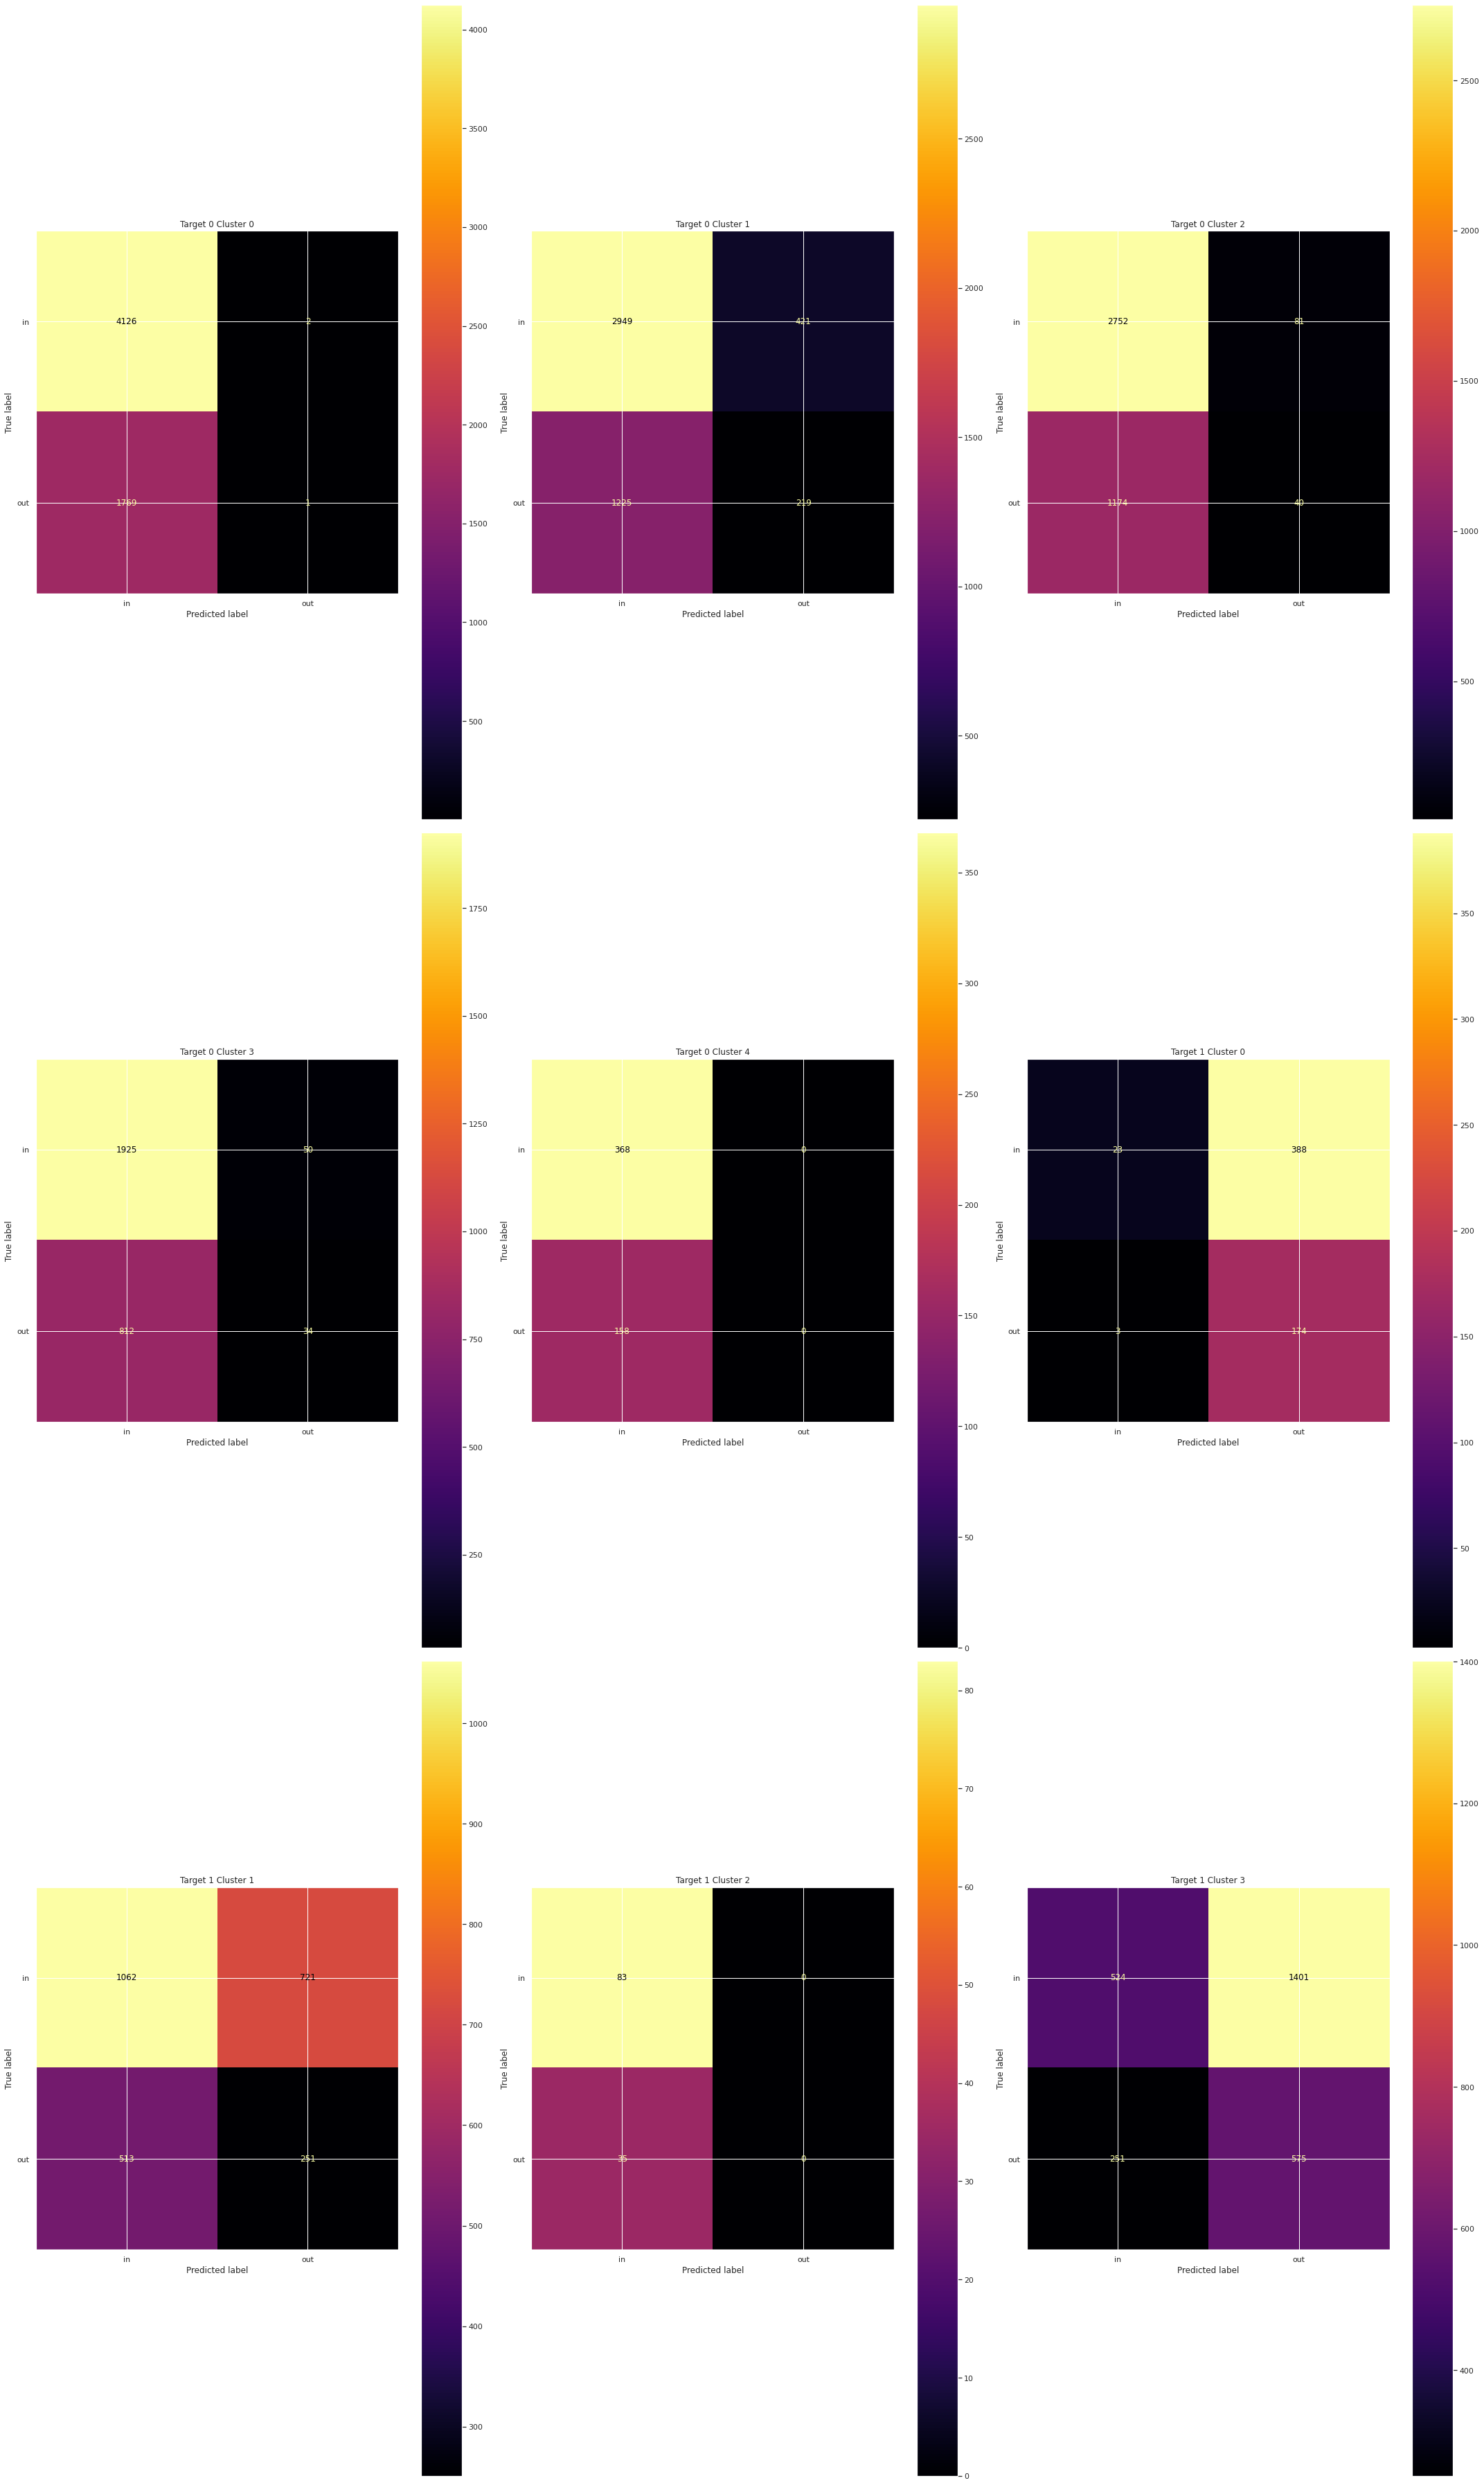

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 50))
axs_list = axs.ravel()
axs_index = 0

for a in adult_test_subset_cluster[['Target', 'Cluster']].groupby(['Target', 'Cluster']):
    indices = a[1].index.values.tolist()
    t,c = a[0][0], a[0][1]
    
    atk0 = []
    atk1 = []
    for ind in indices:
        a0, a1 = get_attack_mod(ind)
        atk0.append(a0)
        atk1.append(a1)
    print(f"HardVoting for {t=} {c=} {indices=}: #Classifiers: Class0 = {len(atk0)} Class1 = {len(atk1)}")
    
    hard_voting_0 = HardVotingClassifier(classifiers=atk0)
    hard_voting_1 = HardVotingClassifier(classifiers=atk1)
    
    
    train_subset = get_subset_target_cluster(adult_train, t, c)
    test_subset  = get_subset_target_cluster(adult_test, t, c)
    
    probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
    probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
    
    ones_train, zeroes_train = split_probs_array(probs_train)
    ones_test, zeroes_test = split_probs_array(probs_test)
    
    # some may be empty
    atk_0_train, atk_1_train, atk_0_test, atk_1_test = [], [], [], []
    
    if len(zeroes_train) > 0:
        atk_0_train = hard_voting_0.predict(zeroes_train)

    if len(ones_train) > 0:
        atk_1_train = hard_voting_1.predict(ones_train)
    
    if len(zeroes_test) > 0:
        atk_0_test = hard_voting_0.predict(zeroes_test)

    if len(ones_test) > 0:
        atk_1_test = hard_voting_1.predict(ones_test)
    
    train_results = np.concatenate((atk_0_train, atk_1_train))
    train_labels  = ["in"] * len(train_results)
    test_results  = np.concatenate((atk_0_test, atk_1_test))
    test_labels   = ["out"] * len(test_results)
    
    full_results  = np.concatenate((train_results, test_results))
    full_labels   = np.concatenate((train_labels, test_labels))
    
    mask = full_results != "even" # exclude from the classification the data with "even"
    
    report_full = classification_report(full_labels[mask], full_results[mask])
    
    with open(str(BASE_VOTING_PATH / f"t{t}_c{c}.txt"), "w") as f:
        f.write(report_full)
    
    ConfusionMatrixDisplay.from_predictions(full_labels[mask], full_results[mask], ax=axs_list[axs_index], cmap='inferno')
    axs_list[axs_index].set_title(f"Target {t} Cluster {c}")
    axs_index += 1
plt.tight_layout()
    